<a id='#start'></a>
### Содержание

<a href='#step1'>1. Подготовка</a>

<a href='#step2'>2. Анализ</a>

<a href='#step3'>3. Обучение</a>

<a href='#step4'>4. Тестирование</a>

<a id='step1'></a>
# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFound:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование по одному часу.

In [4]:
data = data.resample('1H').sum()

<a href='#start'>К содержанию</a>

<a id='step2'></a>
# 2. Анализ

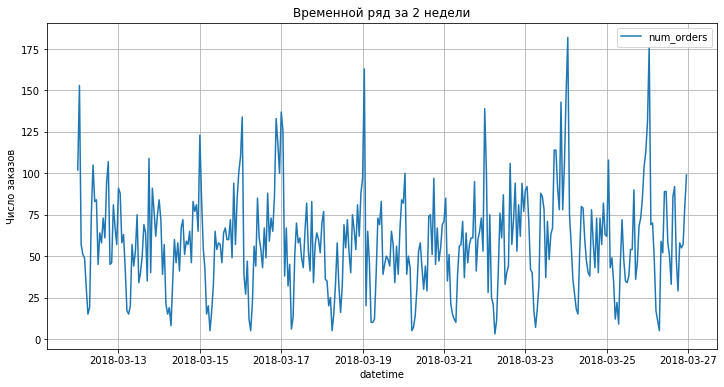

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Временной ряд за 2 недели')
ax.set_ylabel('Число заказов')
ax.grid(True)
sns.lineplot(data=data['2018-03-12':'2018-03-26'])

Изучим, есть ли в нашем временном ряду сезонная компонента. Построим графики для всего ряда, месяца, недели и 3 суток.

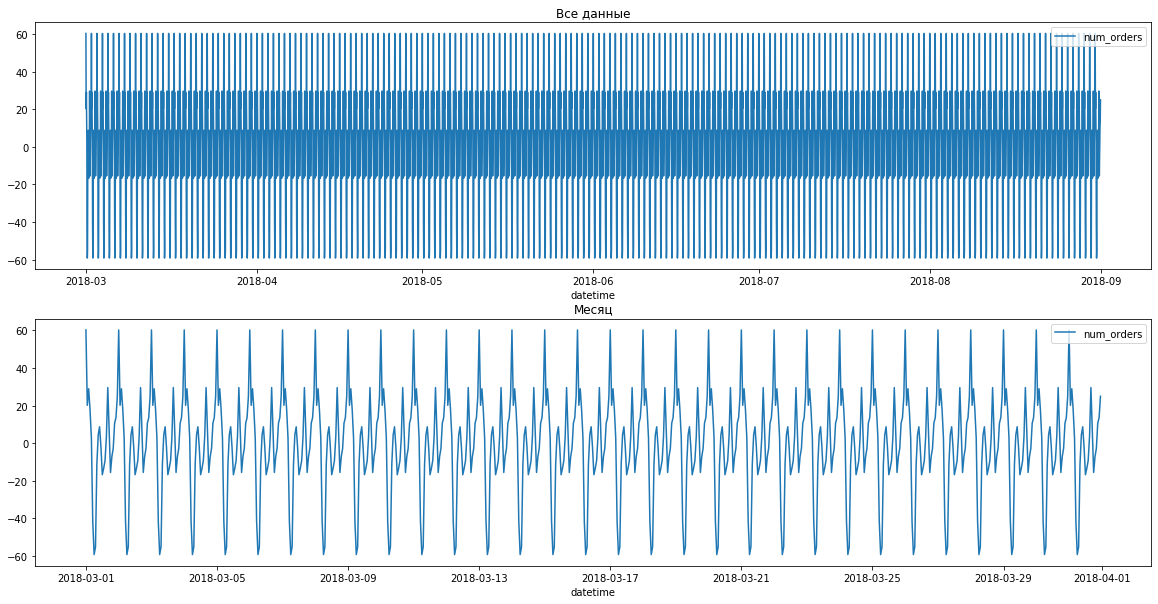

In [6]:
decomposed = seasonal_decompose(data)
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].set_title('Все данные')
ax[1].set_title('Месяц')
sns.lineplot(ax=ax[0], data=decomposed.seasonal['2018-03-01':'2018-08-31'])
sns.lineplot(ax=ax[1], data=decomposed.seasonal['2018-03-01':'2018-03-31'])

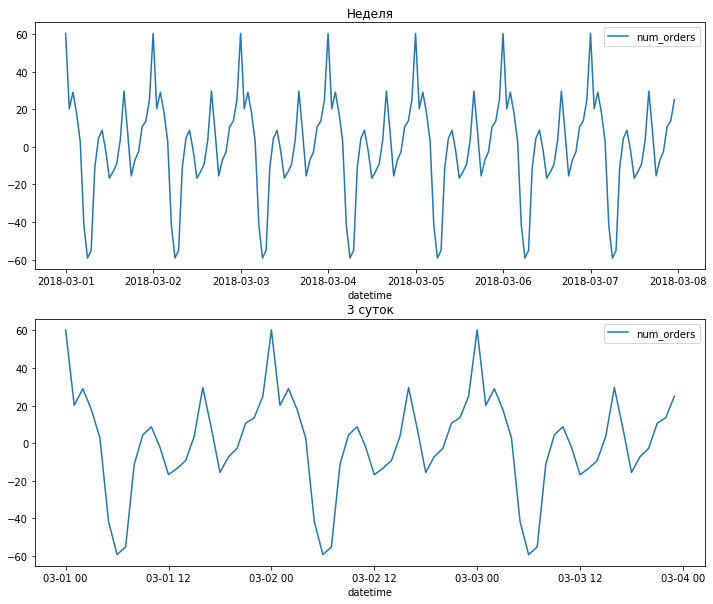

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax[0].set_title('Неделя')
ax[1].set_title('3 суток')
sns.lineplot(ax=ax[0], data=decomposed.seasonal['2018-03-01':'2018-03-07'])
sns.lineplot(ax=ax[1], data=decomposed.seasonal['2018-03-01':'2018-03-03'])

По построенным графикам можем наблюдать суточную сезонность.

Рассмотрим, наблюдается ли трендовость в нашем временном ряду.

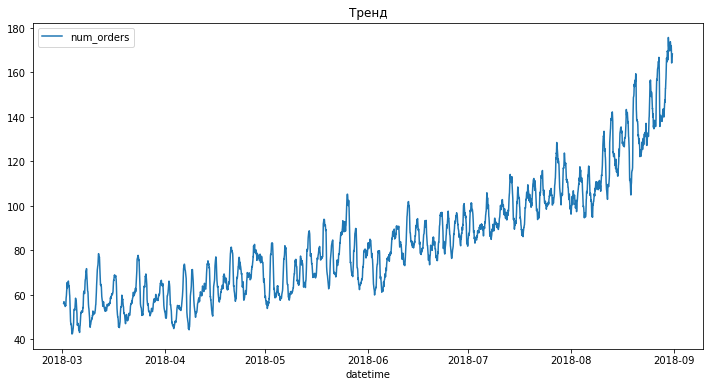

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Тренд')
sns.lineplot(data=decomposed.trend)

По графику можем наблюдать тендецию к росту числа заказов.

<a href='#start'>К содержанию</a>

<a id='step3'></a>
# 3. Обучение

### Функциональная подготовка

Подготовим 2 функции, которые будут использоваться при обучении модели:
- функция создания признаков;
- функция подбора модели.

Функция *make_features* добавляет в указанный датафрейм следующие признаки:
- день недели
- час
- скользящее среднее в соответствии с указанным окном
- признаки с оставанием, начиная с 1, заканчивая максимальным

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Функция *model_selection* осуществляет разделение выборки на тестовую обучающую, а затем, используя функцию **TimeSeriesSplit**, осуществляет перебор параметров в **GridSearchCV**, выводя результаты с лучшими параметрами модели.

In [10]:
def model_selection(data, nfolds, test_s, model, lag, rolling_size, grid_params):
    df = pd.DataFrame(data.copy())
    make_features(df, lag, rolling_size)
    df = df.dropna()
    X = df.drop(['num_orders'], axis=1)
    y = df['num_orders']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=test_s)
    
    tscv = TimeSeriesSplit(n_splits=nfolds)

    grid = GridSearchCV(estimator=model, cv=tscv, param_grid=grid_params, n_jobs=-1, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    print('---------------------------------')
    print('Lag = {}, roll = {}'.format(lag, rolling_size))
    print(grid.best_params_)
    print(np.abs(grid.best_score_)**0.5)
    print()
    return np.abs(grid.best_score_)**0.5

### Подбор параметров

#### Случайный лес

In [11]:
%%time 

forest_param_grid = {
    'max_depth': [int(x) for x in range(2, 30, 5)],
    'n_estimators': [int(x) for x in range(50, 101, 10)]
}

rf = RandomForestRegressor(random_state=127)

results = []

for l in range(3, 8, 1):
    for r in range (2, 13, 2):
        select_res = model_selection(data, 3, 0.1, rf, l, r, forest_param_grid)
        results.append([l, r, select_res])

---------------------------------
Lag = 3, roll = 2
{'max_depth': 17, 'n_estimators': 100}
29.2198238062758

---------------------------------
Lag = 3, roll = 4
{'max_depth': 17, 'n_estimators': 100}
29.168578143706252

---------------------------------
Lag = 3, roll = 6
{'max_depth': 27, 'n_estimators': 60}
28.82067747852658

---------------------------------
Lag = 3, roll = 8
{'max_depth': 22, 'n_estimators': 80}
27.985749467425844

---------------------------------
Lag = 3, roll = 10
{'max_depth': 27, 'n_estimators': 90}
28.034605691136743

---------------------------------
Lag = 3, roll = 12
{'max_depth': 22, 'n_estimators': 90}
27.632668187675495

---------------------------------
Lag = 4, roll = 2
{'max_depth': 27, 'n_estimators': 70}
29.199965998702808

---------------------------------
Lag = 4, roll = 4
{'max_depth': 17, 'n_estimators': 50}
29.199008768376174

---------------------------------
Lag = 4, roll = 6
{'max_depth': 12, 'n_estimators': 100}
29.130199749520838

--------

In [12]:
res_df = pd.DataFrame(data=results, columns=['lag','roll','rmse'])
res_df.sort_values(by=['rmse']).head(10)

,lag,roll,rmse
29,7,12,27.613960
5,3,12,27.632668
23,6,12,27.885525
28,7,10,27.905067
24,7,2,27.932557
17,5,12,27.961380
27,7,8,27.961536
3,3,8,27.985749
4,3,10,28.034606
25,7,4,28.044272


#### LGBM

In [13]:
%%time

lgbm_grid = {
    'max_depth': [int(x) for x in range(2, 20, 3)],
    'learning_rate' : [float(x) for x in np.arange(0.01, 0.2, 0.03)],
    'num_iterations' : [100, 150, 200]
}

lgbm = lgb.LGBMRegressor(random_state=127)

results = []

for l in range(3, 8, 1):
    for r in range (2, 13, 2):
        select_res = model_selection(data, 3, 0.1, lgbm, l, r, lgbm_grid)
        results.append([l, r, select_res])

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
---------------------------------
Lag = 3, roll = 2
{'learning_rate': 0.04, 'max_depth': 11, 'num_iterations': 100}
29.317040222511082

---------------------------------
Lag = 3, roll = 4
{'learning_rate': 0.06999999999999999, 'max_depth': 5, 'num_iterations': 150}
28.871144386709684

---------------------------------
Lag = 3, roll = 6
{'learning_rate': 0.04, 'max_depth': 17, 'num_iterations': 150}
28.403418662935692

---------------------------------
Lag = 3, roll = 8
{'learning_rate': 0.09999999999999999, 'max_depth': 5, 'num_iterations': 100}
27.685112038484025

---------------------------------
Lag = 3, roll = 10
{'learning_rate': 0.06999999999999999, 'max_depth': 5, 'num_iterations': 200}
27.726322788452357

---------------------------------
Lag = 3, roll = 12
{'learning_rate': 0.16, 'max_depth': 2, 'num_iterations': 200}
27.253417814463717

---------------------------------
Lag =

In [14]:
res_df = pd.DataFrame(data=results, columns=['lag','roll','rmse'])
res_df.sort_values(by=['rmse']).head(10)

,lag,roll,rmse
29,7,12,27.104038
5,3,12,27.253418
28,7,10,27.411319
17,5,12,27.439707
23,6,12,27.492568
11,4,12,27.541380
27,7,8,27.587379
25,7,4,27.652236
3,3,8,27.685112
26,7,6,27.686967


#### Линейная регрессия

In [15]:
lr = LinearRegression()

In [16]:
results = []

for l in range(3, 8, 1):
    for r in range (2, 13, 2):
        df = pd.DataFrame(data.copy())
        make_features(df, l, r)
        df = df.dropna()
        X = df.drop(['num_orders'], axis=1)
        y = df['num_orders']
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
        tscv = TimeSeriesSplit(n_splits=3)

        scores = cross_val_score(lr, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error', n_jobs=-1)
        print('---------------------------------')
        print('Lag = {}, roll = {}'.format(l, r))
        print(np.abs(np.mean(scores))**0.5)
        print()

        results.append([l, r, np.abs(np.mean(scores))**0.5])

---------------------------------
Lag = 3, roll = 2
34.26413499200944

---------------------------------
Lag = 3, roll = 4
34.48504055382968

---------------------------------
Lag = 3, roll = 6
34.46233128452025

---------------------------------
Lag = 3, roll = 8
34.08844042839064

---------------------------------
Lag = 3, roll = 10
34.03145277974044

---------------------------------
Lag = 3, roll = 12
33.73868191399362

---------------------------------
Lag = 4, roll = 2
34.48504055382968

---------------------------------
Lag = 4, roll = 4
34.48504055382968

---------------------------------
Lag = 4, roll = 6
34.45252948877097

---------------------------------
Lag = 4, roll = 8
34.03269928805492

---------------------------------
Lag = 4, roll = 10
34.02437222276214

---------------------------------
Lag = 4, roll = 12
33.700860755100386

---------------------------------
Lag = 5, roll = 2
34.45464959721999

---------------------------------
Lag = 5, roll = 4
34.454649597220005



In [17]:
res_df = pd.DataFrame(data=results, columns=['lag','roll','rmse'])
res_df.sort_values(by=['rmse']).head(15)

,lag,roll,rmse
23,6,12,33.695823
11,4,12,33.700861
29,7,12,33.733879
17,5,12,33.735861
5,3,12,33.738682
21,6,8,33.915310
27,7,8,33.946381
10,4,10,34.024372
4,3,10,34.031453
9,4,8,34.032699


## Вывод

Все три модели показали на кросс-валидации хорошие значения **RMSE**, превосходящие целевое.

Выберем для тестирования следующие параметры:
- размер окна, равный 12
- отставание, равное 3.

Не все модели показывают с ними лучшие результаты, однако разница составляет не более 0.1 для значения RMSE, что позволит упростить процесс тестирования.

<a href='#start'>К содержанию</a>

<a id='step4'></a>
# 4. Тестирование

In [18]:
def make_plot(true, pred, plot_title):
    plot_df = true.to_frame()
    plot_df['pred'] = pred
    plot = plot_df.plot(figsize=(18,8), title=plot_title)

Подготовим выборки для обучения и тестирования для датафрейма с получившимся признаками, задав размер тестовой выборки, равный 0.1.

Обучим модели с лучшими параметрами для данных признаков и проведем тестирование.

In [21]:
df = pd.DataFrame(data.copy())
make_features(df, 7, 12)
df = df.dropna()
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [22]:
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(mean_squared_error(y_test, lr_pred)**0.5)

52.68418930761882


In [23]:
lgbm = lgb.LGBMRegressor(learning_rate=0.16, max_depth=2, num_iterations=200, random_state=127)
lgbm.fit(X_train,y_train)
lgbm_pred = lgbm.predict(X_test)
print(mean_squared_error(y_test, lgbm_pred)**0.5)

43.78217158437499


In [24]:
rf = RandomForestRegressor(random_state=127, max_depth=22, n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(mean_squared_error(y_test, rf_pred)**0.5)

44.90811821271159


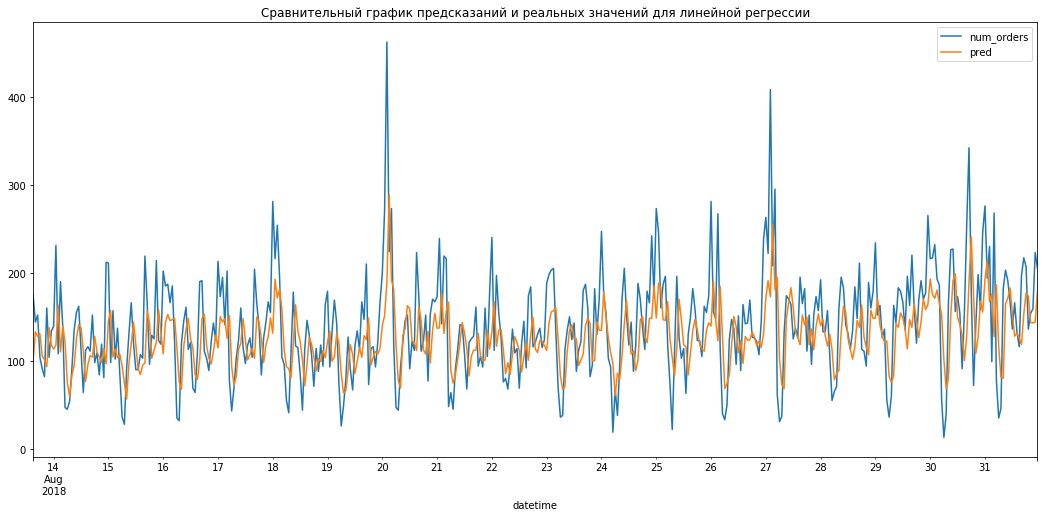

In [25]:
make_plot(y_test, lr_pred, 'Сравнительный график предсказаний и реальных значений для линейной регрессии')

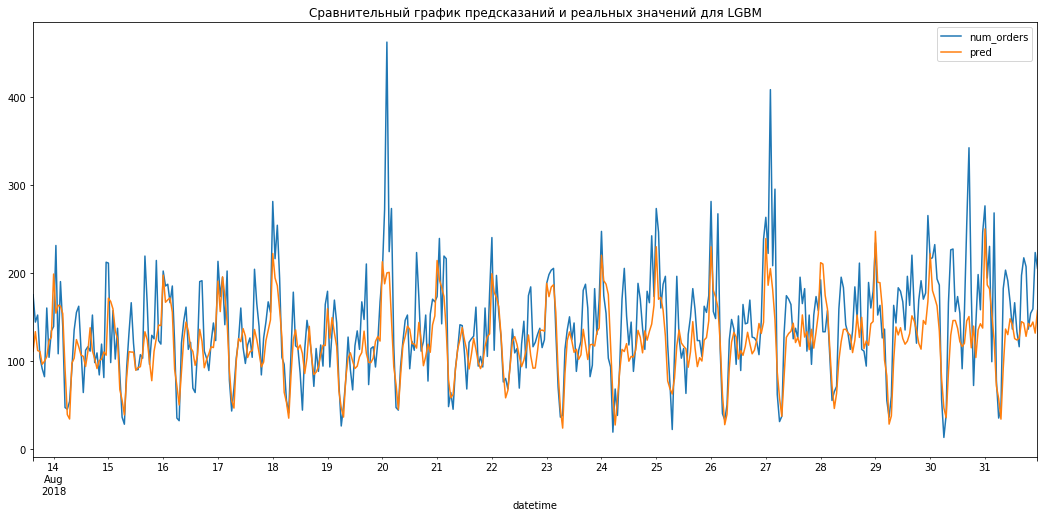

In [26]:
make_plot(y_test, lgbm_pred, 'Сравнительный график предсказаний и реальных значений для LGBM')

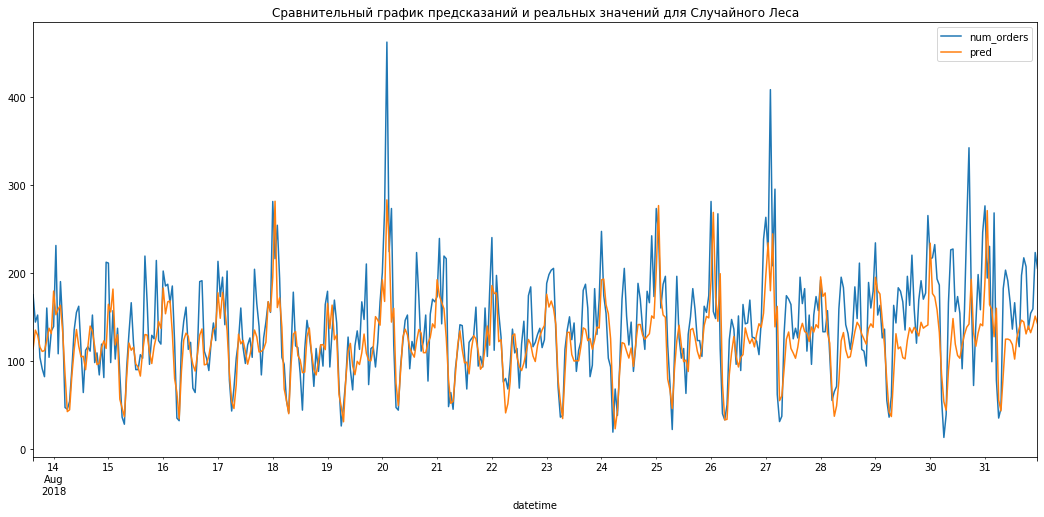

In [27]:
make_plot(y_test, rf_pred, 'Сравнительный график предсказаний и реальных значений для Случайного Леса')

### Выводы

При тестировании лучше всего себя показали модели *случайного леса* и *LGBM*, при этом по графикам можно заметить увеличение отклонения предсказания от фактического значения ближе к концу тестовой выборки.

Мы так же можем наблюдать ухудшение RMSE для каждой модели, что может говорить о некоторой переобученности. Однако, поскольку целевым значением RMSE в задаче является 48, примем полученные результаты подбора моделей.

Лучшей моделью на тестовой выборке стала модель **LGBM** с тестовым значением **RMSE = 43.8**.

<a href='#start'>К содержанию</a>